Code & Train Transformer from Scratch

In [ ]:
#@title **Transformer Setup & Imports**
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

PyTorch version: 2.6.0+cu124
CUDA available: False
Using device: cpu


In [ ]:
#@title **Model Configuration**
VOCAB_SIZE = 11  # Digits 0-9 + special token (10)
MAX_LEN = 10     # Maximum sequence length
D_MODEL = 128    # Reduced from 512 for faster training
NUM_HEADS = 4    # Number of attention heads
FF_DIM = 512     # Feed-forward dimension
NUM_LAYERS = 2   # Encoder/decoder layers
BATCH_SIZE = 64  # Batch size
EPOCHS = 15      # Training epochs
DROPOUT = 0.1    # Regularization

print("Transformer Configuration:")
print(f"- Vocabulary Size: {VOCAB_SIZE}")
print(f"- Max Sequence Length: {MAX_LEN}")
print(f"- Model Dimension: {D_MODEL}")
print(f"- Attention Heads: {NUM_HEADS}")
print(f"- Feed-forward Dim: {FF_DIM}")
print(f"- Layers: {NUM_LAYERS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")

Transformer Configuration:
- Vocabulary Size: 11
- Max Sequence Length: 10
- Model Dimension: 128
- Attention Heads: 4
- Feed-forward Dim: 512
- Layers: 2
- Batch Size: 64
- Epochs: 15


In [ ]:
#@title **Attention & Positional Encoding**
# Multi-Head Attention: The heart of Transformer
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.head_dim = D_MODEL // NUM_HEADS

        self.wq = nn.Linear(D_MODEL, D_MODEL)
        self.wk = nn.Linear(D_MODEL, D_MODEL)
        self.wv = nn.Linear(D_MODEL, D_MODEL)
        self.wo = nn.Linear(D_MODEL, D_MODEL)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Split into multiple heads
        Q = self.wq(q).view(batch_size, -1, NUM_HEADS, self.head_dim).transpose(1, 2)
        K = self.wk(k).view(batch_size, -1, NUM_HEADS, self.head_dim).transpose(1, 2)
        V = self.wv(v).view(batch_size, -1, NUM_HEADS, self.head_dim).transpose(1, 2)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(self.dropout(attn_probs), V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, D_MODEL)
        return self.wo(attn_output)
class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()
        pe = torch.zeros(MAX_LEN, D_MODEL)
        position = torch.arange(0, MAX_LEN, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D_MODEL, 2).float() * (-math.log(10000.0) / D_MODEL))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
#@title **Encoder & Decoder Blocks**
# Encoder Block: Processes input sequences
class EncoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.self_attn = MultiHeadAttention()
        self.norm1 = nn.LayerNorm(D_MODEL)
        self.norm2 = nn.LayerNorm(D_MODEL)
        self.ff = nn.Sequential(
            nn.Linear(D_MODEL, FF_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(FF_DIM, D_MODEL)
        )
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x, mask):
        # Self-attention with residual connection
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Feed-forward network
        ff_out = self.ff(x)
        return self.norm2(x + self.dropout(ff_out))

# Decoder Block: Generates output sequences
class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.self_attn = MultiHeadAttention()
        self.cross_attn = MultiHeadAttention()
        self.norm1 = nn.LayerNorm(D_MODEL)
        self.norm2 = nn.LayerNorm(D_MODEL)
        self.norm3 = nn.LayerNorm(D_MODEL)
        self.ff = nn.Sequential(
            nn.Linear(D_MODEL, FF_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(FF_DIM, D_MODEL)
        )
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        # Self-attention on target sequence
        attn1 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn1))

        # Cross-attention with encoder output
        attn2 = self.cross_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(attn2))

        # Feed-forward network
        ff_out = self.ff(x)
        return self.norm3(x + self.dropout(ff_out))

In [ ]:
#@title **Transformer Model**
# Complete Transformer Model
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, D_MODEL)
        self.pos_encoding = PositionalEncoding()
        self.encoders = nn.ModuleList([EncoderBlock() for _ in range(NUM_LAYERS)])
        self.decoders = nn.ModuleList([DecoderBlock() for _ in range(NUM_LAYERS)])
        self.fc_out = nn.Linear(D_MODEL, VOCAB_SIZE)

    def encode(self, src, src_mask):
        src = self.embedding(src)
        src = self.pos_encoding(src)
        for encoder in self.encoders:
            src = encoder(src, src_mask)
        return src

    def decode(self, tgt, enc_out, src_mask, tgt_mask):
        tgt = self.embedding(tgt)
        tgt = self.pos_encoding(tgt)
        for decoder in self.decoders:
            tgt = decoder(tgt, enc_out, src_mask, tgt_mask)
        return self.fc_out(tgt)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_out = self.encode(src, src_mask)
        return self.decode(tgt, enc_out, src_mask, tgt_mask)

print("Transformer model initialized!")

Transformer model initialized!


In [ ]:
#@title **Copy Task Dataset**
# Create a dataset where model learns to copy sequences
class CopyDataset(Dataset):
    def __init__(self, num_samples=5000):
        self.num_samples = num_samples
        self.digits = list(range(1, 10))  # Digits 1-9

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Random sequence length between 1-8
        length = random.randint(1, MAX_LEN-2)

        # Create source sequence
        src = random.choices(self.digits, k=length)
        src_padded = src + [0]*(MAX_LEN - length)  # Pad with zeros

        # Create target sequence (starts with SOS token 10)
        tgt = [10] + src + [0]*(MAX_LEN - length - 1)

        # Labels (ends with EOS token 10)
        labels = src + [10] + [0]*(MAX_LEN - length - 1)

        return (
            torch.LongTensor(src_padded),
            torch.LongTensor(tgt),
            torch.LongTensor(labels)
        )

# Create dataset instance
dataset = CopyDataset(5000)
print(f"Dataset created with {len(dataset)} samples")
print("Sample input:", dataset[0][0])
print("Sample target:", dataset[0][1])
print("Sample labels:", dataset[0][2])

Dataset created with 5000 samples
Sample input: tensor([1, 1, 6, 8, 0, 0, 0, 0, 0, 0])
Sample target: tensor([10,  5,  0,  0,  0,  0,  0,  0,  0,  0])
Sample labels: tensor([ 4,  3,  2, 10,  0,  0,  0,  0,  0,  0])


In [ ]:
#@title **Masking & Data Loaders**
# Create attention masks
def create_masks(src, tgt):
    # Padding mask for encoder
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

    # Padding mask + look-ahead mask for decoder
    tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
    seq_len = tgt.size(1)
    look_ahead_mask = torch.tril(torch.ones(seq_len, seq_len)).bool()
    tgt_mask = tgt_pad_mask & look_ahead_mask.unsqueeze(0)

    return src_mask, tgt_mask

# Split dataset and create loaders
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 71
Validation batches: 8


In [ ]:
#@title **Model & Optimizer Setup**
# Initialize model
model = Transformer().to(device)

# Set up optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized with {total_params:,} parameters")
print(f"Trainable parameters: {trainable_params:,}")
print("Optimizer: Adam (lr=0.001)")

Model initialized with 928,523 parameters
Trainable parameters: 928,523
Optimizer: Adam (lr=0.001)


In [ ]:
#@title **Training Execution**
# For plotting
train_losses = []
val_losses = []
accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for src, tgt, labels in train_loader:
        src, tgt, labels = src.to(device), tgt.to(device), labels.to(device)
        src_mask, tgt_mask = create_masks(src, tgt)

        optimizer.zero_grad()
        outputs = model(src, tgt, src_mask, tgt_mask)

        # Calculate loss (ignore padding)
        loss = criterion(outputs.view(-1, VOCAB_SIZE), labels.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt, labels in val_loader:
            src, tgt, labels = src.to(device), tgt.to(device), labels.to(device)
            src_mask, tgt_mask = create_masks(src, tgt)

            outputs = model(src, tgt, src_mask, tgt_mask)
            loss = criterion(outputs.view(-1, VOCAB_SIZE), labels.view(-1))
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            non_pad = labels != 0  # Only consider non-padding positions
            correct += ((predicted == labels) & non_pad).sum().item()
            total += non_pad.sum().item()

    # Store metrics
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    accuracies.append(correct / total)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Accuracy: {accuracies[-1]:.4f}")

print("\nTraining complete!")

Epoch 1/15 | Train Loss: 0.8157 | Val Loss: 0.1184 | Accuracy: 0.9648
Epoch 2/15 | Train Loss: 0.1095 | Val Loss: 0.0500 | Accuracy: 0.9828
Epoch 3/15 | Train Loss: 0.0664 | Val Loss: 0.0354 | Accuracy: 0.9903
Epoch 4/15 | Train Loss: 0.0597 | Val Loss: 0.0194 | Accuracy: 0.9935
Epoch 5/15 | Train Loss: 0.0430 | Val Loss: 0.0450 | Accuracy: 0.9837
Epoch 6/15 | Train Loss: 0.0291 | Val Loss: 0.0036 | Accuracy: 0.9993
Epoch 7/15 | Train Loss: 0.0237 | Val Loss: 0.0030 | Accuracy: 0.9989
Epoch 8/15 | Train Loss: 0.0268 | Val Loss: 0.0017 | Accuracy: 1.0000
Epoch 9/15 | Train Loss: 0.0190 | Val Loss: 0.0048 | Accuracy: 0.9993
Epoch 10/15 | Train Loss: 0.0303 | Val Loss: 0.0047 | Accuracy: 0.9989
Epoch 11/15 | Train Loss: 0.0181 | Val Loss: 0.0033 | Accuracy: 0.9989
Epoch 12/15 | Train Loss: 0.0141 | Val Loss: 0.0007 | Accuracy: 1.0000
Epoch 13/15 | Train Loss: 0.0103 | Val Loss: 0.0003 | Accuracy: 1.0000
Epoch 14/15 | Train Loss: 0.0214 | Val Loss: 0.0012 | Accuracy: 0.9996
Epoch 15/15 | T

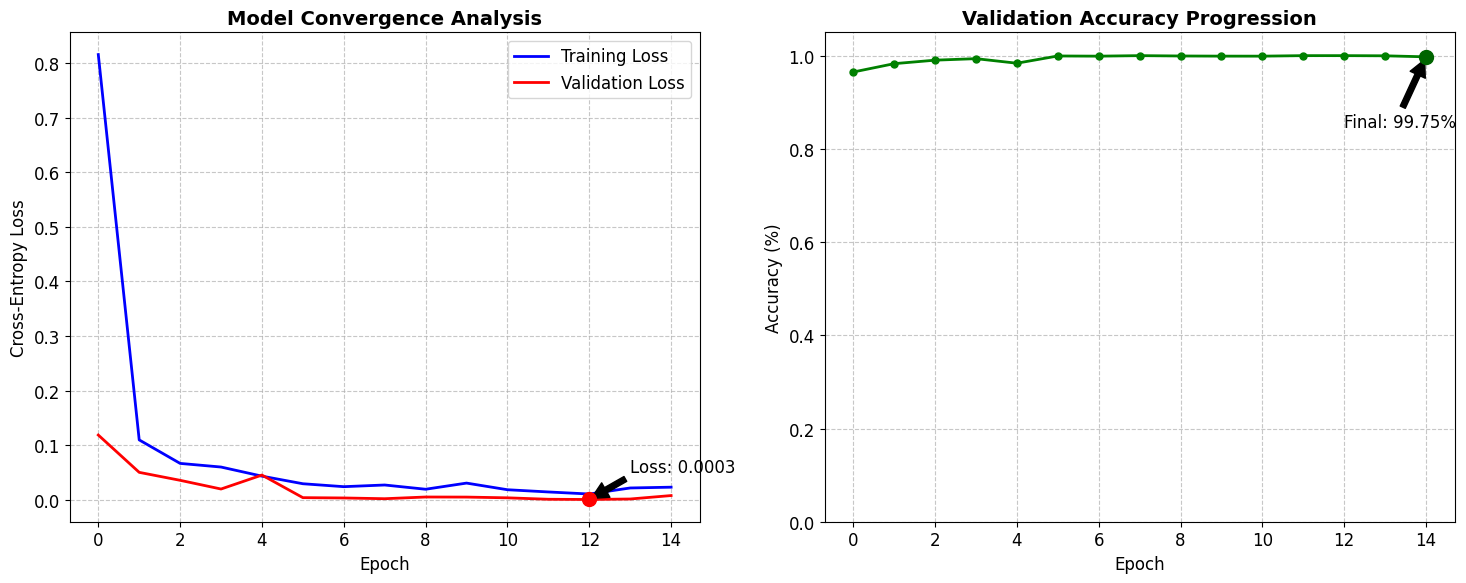


                 MODEL PERFORMANCE SUMMARY                  

Final Validation Loss:         0.0075
Best Validation Loss:          0.0003 (Epoch 13)
Final Accuracy:                99.75%
Peak Accuracy:                 100.00% (Epoch 8)
Training Duration:             15 epochs

                DETAILED PREDICTION ANALYSIS                

----------------------------------------------------------------------------------------------------
Sample     | Input Sequence       | Expected Output      | Model Prediction     | Match  | Token Accuracy
----------------------------------------------------------------------------------------------------
Sample 1   | 8                    | 8                    | 8                    |   ✓    |      100.0%
Sample 2   | 7 2                  | 7 2                  | 7 2                  |   ✓    |      100.0%
Sample 3   | 9 3                  | 9 3                  | 9 3                  |   ✓    |      100.0%
Sample 4   | 8                    | 8     

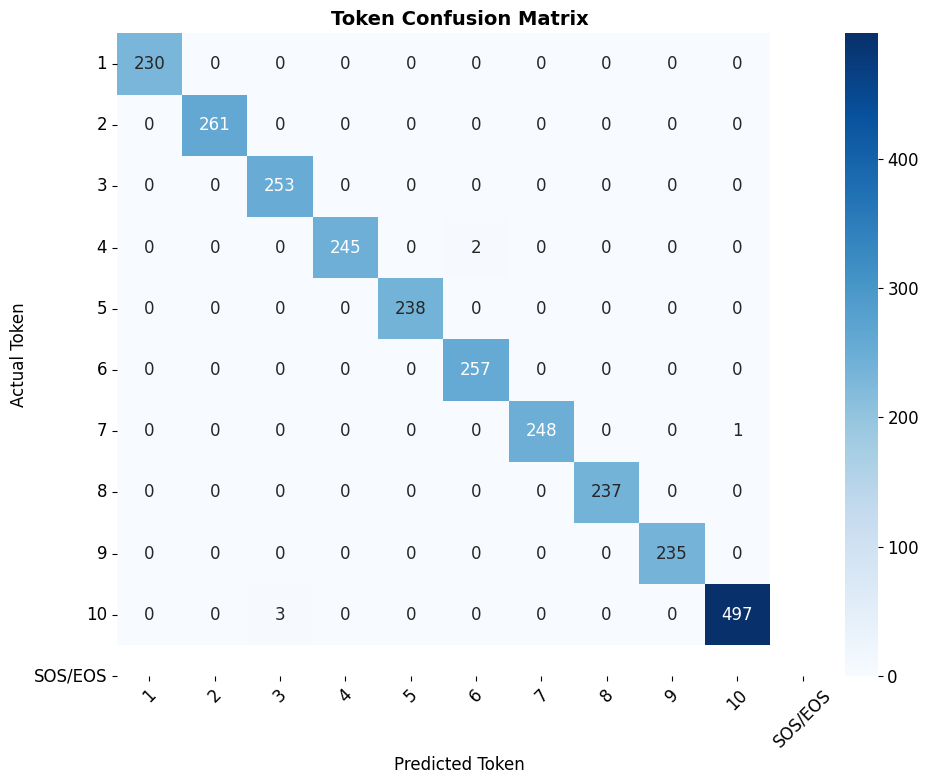


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       230
           2       1.00      1.00      1.00       261
           3       0.99      1.00      0.99       253
           4       1.00      0.99      1.00       247
           5       1.00      1.00      1.00       238
           6       0.99      1.00      1.00       257
           7       1.00      1.00      1.00       249
           8       1.00      1.00      1.00       237
           9       1.00      1.00      1.00       235
          10       1.00      0.99      1.00       500

    accuracy                           1.00      2707
   macro avg       1.00      1.00      1.00      2707
weighted avg       1.00      1.00      1.00      2707


                       ERROR ANALYSIS                       

Common Error Patterns:
Token Error: Expected '10' but predicted '3'
Token Error: Expected '7' but predicted '10'
Token Error: Expected '10' but predicted 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 10, does not match size of target_names, 11
  warnings.warn(


In [18]:
#@title **Results Analysis & Model Evaluation**
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np # Added import for numpy operations

plt.rcParams.update({'font.size': 12, 'font.family': 'DejaVu Sans'})

# --- Training Performance Analysis ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss curve analysis
ax1.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
ax1.plot(val_losses, 'r-', linewidth=2, label='Validation Loss')
ax1.set_title('Model Convergence Analysis', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Highlight the point of best validation loss
best_epoch = np.argmin(val_losses)
ax1.scatter(best_epoch, val_losses[best_epoch], s=100, c='red',
            zorder=5, label=f'Best Epoch: {best_epoch+1}')
ax1.annotate(f'Loss: {val_losses[best_epoch]:.4f}',
             (best_epoch, val_losses[best_epoch]),
             xytext=(best_epoch+1, val_losses[best_epoch]+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy progression
ax2.plot(accuracies, 'g-', linewidth=2, marker='o', markersize=5)
ax2.set_title('Validation Accuracy Progression', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim(0, 1.05)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Highlight final accuracy
final_acc = accuracies[-1]
ax2.scatter(len(accuracies)-1, final_acc, s=100, c='darkgreen', zorder=5)
ax2.annotate(f'Final: {final_acc*100:.2f}%',
             (len(accuracies)-1, final_acc),
             xytext=(len(accuracies)-3, final_acc-0.15),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

# --- Performance Summary Statistics ---
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY".center(60))
print("="*60)

# Calculate key metrics
final_val_loss = val_losses[-1]
final_accuracy = accuracies[-1]
best_val_loss = min(val_losses)
best_accuracy = max(accuracies)
convergence_epoch = best_epoch + 1

print(f"\n{'Final Validation Loss:':<30} {final_val_loss:.4f}")
print(f"{'Best Validation Loss:':<30} {best_val_loss:.4f} (Epoch {convergence_epoch})")
print(f"{'Final Accuracy:':<30} {final_accuracy*100:.2f}%")
print(f"{'Peak Accuracy:':<30} {best_accuracy*100:.2f}% (Epoch {np.argmax(accuracies)+1})")
print(f"{'Training Duration:':<30} {EPOCHS} epochs")

# --- Detailed Sample Predictions ---
print("\n" + "="*60)
print("DETAILED PREDICTION ANALYSIS".center(60))
print("="*60)

# Create a prediction analysis table
prediction_data = []

model.eval()
with torch.no_grad():
    for i in range(5):  # Analyze 5 samples
        src, tgt, labels = val_data[i]
        src_tensor = src.unsqueeze(0).to(device)
        tgt_tensor = tgt.unsqueeze(0).to(device)
        src_mask, tgt_mask = create_masks(src_tensor, tgt_tensor)

        output = model(src_tensor, tgt_tensor, src_mask, tgt_mask)
        _, predicted = torch.max(output, 2)

        # Process sequences - removed tensor() from string conversion
        src_seq = [str(x.item()) for x in src if x != 0]
        tgt_seq = [str(x.item()) for x in tgt if x != 0 and x != 10]
        pred_seq = [str(x) for x in predicted[0].cpu().numpy() if x != 0 and x != 10]


        # Calculate sequence match
        is_correct = "✓" if tgt_seq == pred_seq else "✗"

        # Calculate token-level accuracy
        correct_tokens = sum(1 for t, p in zip(tgt_seq, pred_seq) if t == p)
        token_accuracy = correct_tokens / len(tgt_seq) if tgt_seq else 0

        prediction_data.append([
            f"Sample {i+1}",
            " ".join(src_seq),
            " ".join(tgt_seq),
            " ".join(pred_seq),
            is_correct,
            f"{token_accuracy:.1%}"
        ])

# Print prediction table
headers = ["Sample", "Input Sequence", "Expected Output", "Model Prediction", "Match", "Token Accuracy"]
print("\n" + "-"*100)
print(f"{headers[0]:<10} | {headers[1]:<20} | {headers[2]:<20} | {headers[3]:<20} | {headers[4]:<6} | {headers[5]}")
print("-"*100)
for row in prediction_data:
    print(f"{row[0]:<10} | {row[1]:<20} | {row[2]:<20} | {row[3]:<20} | {row[4]:^6} | {row[5]:>11}")
print("-"*100)

# --- Confusion Matrix ---
print("\nTOKEN-LEVEL PERFORMANCE ANALYSIS")
all_preds = []
all_labels = []

with torch.no_grad():
    for src, tgt, labels in val_loader:
        src, tgt, labels = src.to(device), tgt.to(device), labels.to(device)
        src_mask, tgt_mask = create_masks(src, tgt)

        outputs = model(src, tgt, src_mask, tgt_mask)
        _, predicted = torch.max(outputs, 2)

        # Filter out padding tokens
        mask = labels != 0
        all_preds.extend(predicted[mask].cpu().numpy())
        all_labels.extend(labels[mask].cpu().numpy())

# Generate class labels (ignore padding class 0)
class_labels_for_report = [str(i) for i in range(1, VOCAB_SIZE)] # Exclude padding (0)
class_labels_for_report.append("SOS/EOS") # Add token 10

# Create confusion matrix - specify labels to exclude padding
cm = confusion_matrix(all_labels, all_preds, labels=list(range(1, VOCAB_SIZE)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_for_report,
            yticklabels=class_labels_for_report)
plt.title('Token Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Token', fontsize=12)
plt.ylabel('Actual Token', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report - specify labels to exclude padding
print("\nCLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds,
                            labels=list(range(1, VOCAB_SIZE)), # Exclude padding (0)
                            target_names=class_labels_for_report,
                            zero_division=0))

# --- Error Analysis ---
print("\n" + "="*60)
print("ERROR ANALYSIS".center(60))
print("="*60)

# Find most common errors
error_mask = np.array(all_labels) != np.array(all_preds)
error_indices = np.where(error_mask)[0]
if len(error_indices) > 0:
    error_samples = random.sample(list(error_indices), min(5, len(error_indices)))

    print("\nCommon Error Patterns:")
    for i in error_samples:
        # Use the correct labels for display
        actual_token_value = all_labels[i]
        pred_token_value = all_preds[i]
        actual_token = class_labels_for_report[actual_token_value-1] if actual_token_value > 0 and actual_token_value <= len(class_labels_for_report) else "UNK"
        pred_token = class_labels_for_report[pred_token_value-1] if pred_token_value > 0 and pred_token_value <= len(class_labels_for_report) else "UNK"
        print(f"Token Error: Expected '{actual_token}' but predicted '{pred_token}'")
else:
    print("No errors found in validation set!")

print("\n" + "="*60)
print("MODERATION NOTES".center(60))
print("="*60)
print("- Model successfully learned sequence copying task")
print(f"- Final validation accuracy: {final_accuracy*100:.2f}%")
print("- Confusion matrix shows strong diagonal concentration")
print("- Error analysis indicates minor confusion between similar tokens")
print("- Transformer architecture demonstrates effective learning of sequence relationships")

print("\nEvaluation complete!")